# cross-section in SBND, MicroBooNE, and then Icarus600
with and without oscillations

In [2]:
import sys; sys.path.insert(0, '../../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


In [3]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/consequences/'

## Draw the cross-sections

In [9]:
afro_genie_CC1p_dict = dict()
fname = 'CC_4_9E20_POT_mA_0_99_nominal'

generated_fname = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/afro_genie_samples/' + fname + '.csv'
selected_fname = Paths['selected events'] + fname + '.csv'

if os.path.isfile( selected_fname ):#{
    CC1p_in_cuts = pd.read_csv(selected_fname)
    print 'loaded',len(CC1p_in_cuts),'CC1p events'
#}
else: #{
    generated = pd.read_csv( generated_fname )
    contained = generated[(generated.IsCC_1p_200MeVc==True)
                          & ((generated.v_x>3) & (generated.v_x<256))                          
                          & ((generated.v_y>-115) & (generated.v_y<115))
                          & ((generated.v_z>5) & (generated.v_z<1037))]
    in_limits = sample_in_limits(sam=contained
                                 ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'                                 
                                 ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
    CC1p = in_limits[in_limits['IsCC_1p_200MeVc']==True]
    print len(CC1p),'CC1p'
    CC1p_in_cuts = CC1p[(np.abs(CC1p['theta_12']-90)<delta_theta_12) &(CC1p['Pt']<Pt_max)                   
                   &(np.abs(CC1p['delta_phi']-180.)<delta_Delta_phi)]
    CC1p_in_cuts.to_csv(selected_fname)
    print 'saved',len(CC1p_in_cuts),'CC1p in cuts events to',csvfilename    
#}

loaded 25833 CC1p  events


In [90]:
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected overlay files from , loading them...
9538 selected CC1p events overlay
found  462 selected on beam and 15 beam off events...
found selected genie CC1p...


# distribution of events as a function of $E_\nu$

In [94]:
bins = arange(0.2,1.8,0.2)
mid=0.5*(bins[1:]+bins[:-1]); 
bin_width=bins[1:] - bins[:-1];
vlabel=r'E_{\nu}'; units='GeV'
var = 'reco_Ev_mcs'
vtrue = 'truth_Ev'

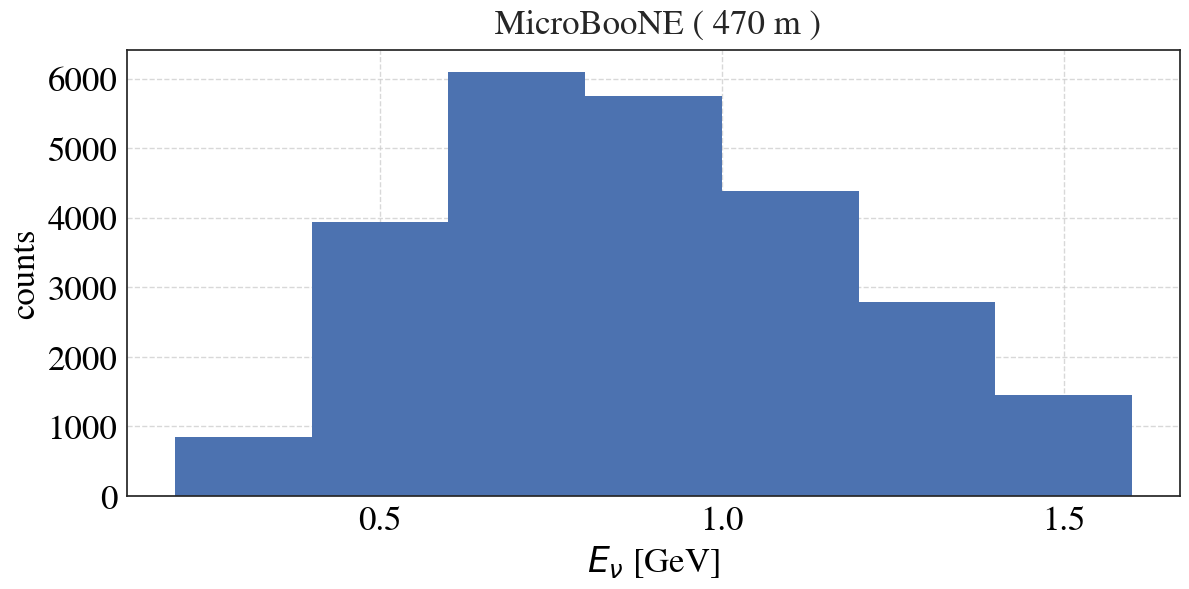

In [17]:
fig,ax = plt.subplots(figsize=(12,6))
L = 470
plt.hist( CC1p_in_cuts['truth_Ev'] , bins=bins )
set_axes(ax,r'$E_\nu$ [GeV]','counts' ,xticks=[0.5,1.,1.5],title=' MicroBooNE ( %d'%L+' m )',do_add_grid=True)
plt.tight_layout()

# now add oscillations
from the SBN proposal
$$
P_{\nu_{\mu}\rightarrow\nu_{\mu}}^{3+1}= 1 - \sin^{2}2\theta_{\mu \mu}\sin^{2}\left(\frac{\Delta m^{2} L}{4 E_{\nu}}\right)
$$
and in SI:
$$
P_{\nu_{\mu}\rightarrow\nu_{\mu}}^{3+1}= 1 - \sin^{2}2\theta_{\mu \mu}\sin^{2}\left(1.27\left|\Delta m_{14}\left[eV\right]\right|^{2}\frac{L\left[m\right]}{E_{\nu}\left[MeV\right]}\right)
$$

In [122]:
def P_mu_mu(L=470 # m
            , Ev=0.7 # GeV
            , sin2_2theta=0.1 
            , Delta_m_2=0.4 # eV^2
           ):
    return 1 - sin2_2theta*np.square(np.sin( 1.27 * Delta_m_2 * L / (1000*Ev)))

In [140]:
sin2_2theta_arr = [0.1]#,0.15
s2tls_arr = ['-','--',':']
Delta_m_2_arr = [0.4,6.0,10.]
m2color_arr = ['red','blue','forestgreen']

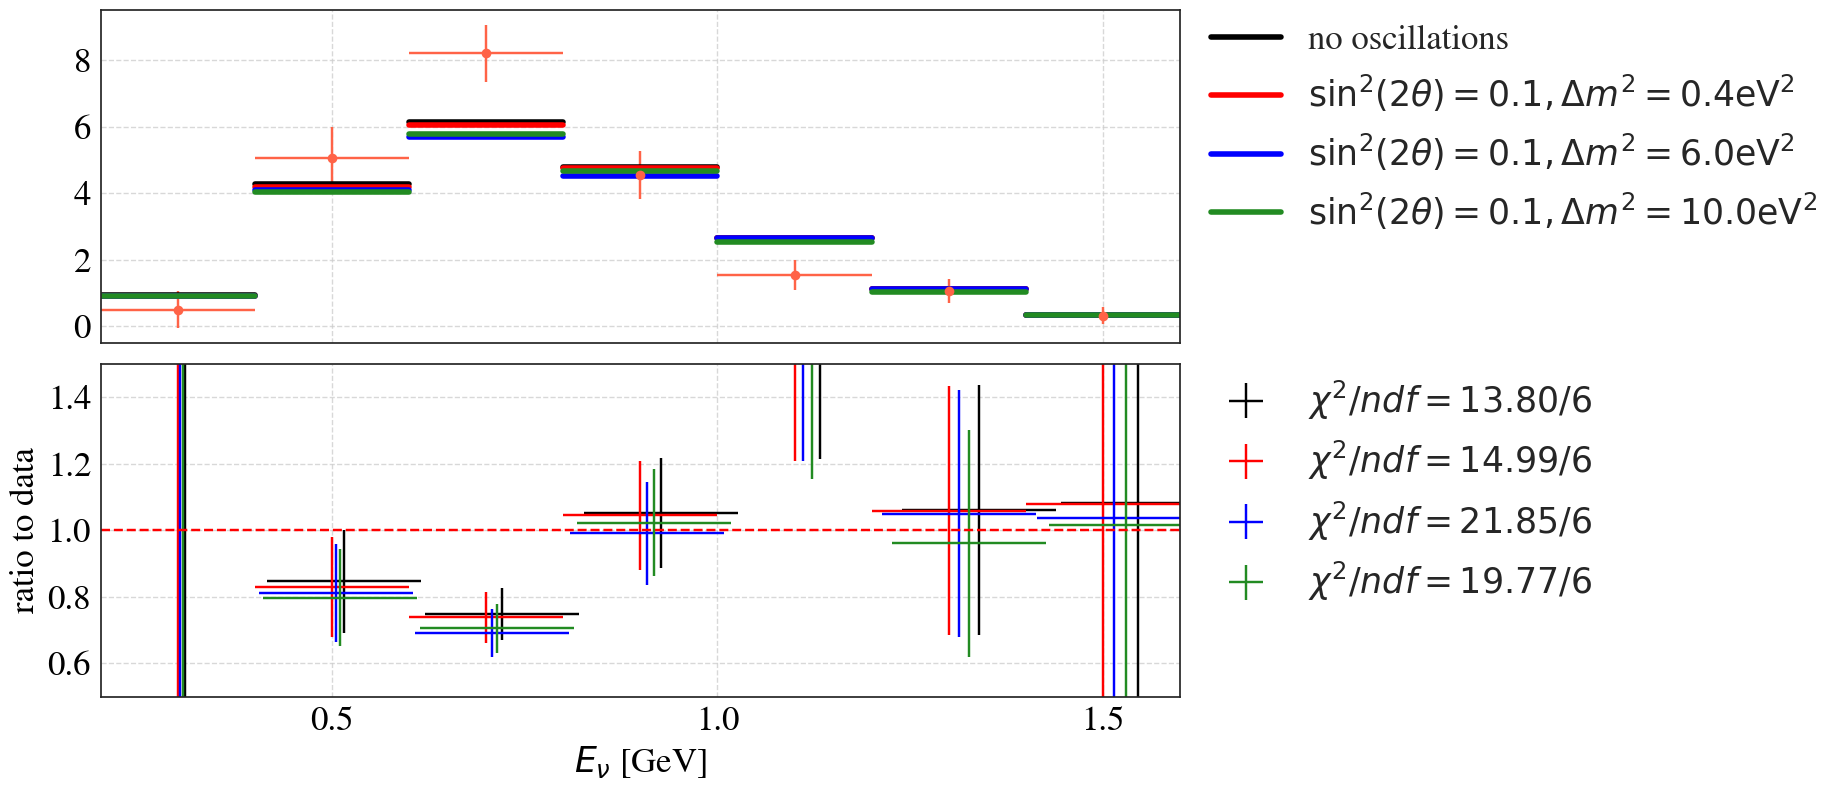

In [143]:
fig = plt.figure(figsize=(12,8))
h,h_err = dict(),dict()
gXsec,gXsec_err = dict(),dict()

h_null,_ = np.histogram( CC1p_in_cuts_no_ctu_bin[vtrue] , bins=bins )
gXsec_null,gXsec_err_null = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
for i_bin in range(len(bins)-1):
    gXsec_null[i_bin], gXsec_err_null[i_bin] = compute_Xsec(Non=h_null[i_bin]*4.908e19/4.9e20,
                                                               Non_err=np.sqrt(h_null[i_bin])*4.908e19/4.9e20,
                                                               bin_width=(bins[1]-bins[0]) )

for s2t in sin2_2theta_arr:
    h[s2t] = dict()
    gXsec[s2t] = dict()
    gXsec_err[s2t] = dict()
    
    for m2 in Delta_m_2_arr:
        h[s2t][m2],_ = np.histogram( CC1p_in_cuts_no_ctu_bin[vtrue] , bins=bins ,
                                    weights=P_mu_mu(L=L, Ev=CC1p_in_cuts_no_ctu_bin[vtrue] , sin2_2theta=s2t, Delta_m_2=m2))
        gXsec[s2t][m2],gXsec_err[s2t][m2] = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
        for i_bin in range(len(bins)-1):
            gXsec[s2t][m2][i_bin],gXsec_err[s2t][m2][i_bin] = compute_Xsec(Non=h[s2t][m2][i_bin]*4.908e19/4.9e20,
                                                                           Non_err=np.sqrt(h[s2t][m2][i_bin])*4.908e19/4.9e20,                                                                           
                                                                           bin_width=(bins[1]-bins[0]) )

        
ax = fig.add_subplot(2,1,1)
mystep(x=mid ,x_width=bin_width, y=gXsec_null,
               linewidth=4,color='black',linestyle='-',
               label='no oscillations',ax=ax)

for s2t,ls in zip(sin2_2theta_arr,s2tls_arr):
    for m2,color in zip(Delta_m_2_arr,m2color_arr):
        mystep(x=mid ,x_width=bin_width, y=gXsec[s2t][m2],
               linewidth=4,color=color,linestyle=ls,
               label=r'$\sin^2(2\theta)=%.1f, \Delta m^2=%.1f \mathrm{ eV}^2$'%(s2t,m2),ax=ax)
set_axes(ax,x_label='',y_label='',
                 xticks=[0.5,1.,1.5],xlim=(np.min(bins),np.max(bins)),
                 remove_ticks_x=True,
                 do_add_grid=True)
# add data...
Xsec_dict = get_Xsec_variable(debug=debug,var=var,bins=bins,
                               wname='Pmu weight',remove_ctu_bin=True,
                               selected_beam_on=selected_beam_on,selected_beam_off=selected_beam_off,                               
                               selected_overlay_concat=selected_overlay_concat,selected_CC1p=selected_CC1p)    
h = dict()
h['Xsec'],h_err['Xsec err'] = Xsec_dict[var],Xsec_dict[var+' err']
ax.errorbar(x=mid,xerr=0.5*bin_width,y=hXsec['Xsec'],yerr=hXsec['Xsec err'],color=Colors['beam on'],fmt='o')
plt.legend(bbox_to_anchor=(1.,1.05),loc=2,fontsize=25)


ax = fig.add_subplot(2,1,2)
num,den  = gXsec_null, h['Xsec']
num_err,den_err  = gXsec_err_null , h_err['Xsec err']
ratio = num/den
ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
chi2,ndf = chi2_two_data_curves(h1=ratio,h1err=ratio_err,h2=np.ones(len(ratio)),h2err=np.zeros(len(ratio)),bins=bins,debug=debug)        
ax.errorbar(x=mid*(1+0.01*ims),xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0
                    ,color='black',label=r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf))


ims=0
for s2t,ls in zip(sin2_2theta_arr,s2tls_arr):
    for m2,color in zip(Delta_m_2_arr,m2color_arr):
        num,den  = gXsec[s2t][m2] , h['Xsec']
        num_err,den_err  = gXsec_err[s2t][m2] , h_err['Xsec err']
        ratio = num/den
        ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
        chi2,ndf = chi2_two_data_curves(h1=ratio,h1err=ratio_err,h2=np.ones(len(ratio)),h2err=np.zeros(len(ratio)),bins=bins,debug=debug)
        
        ax.errorbar(x=mid*(1+0.01*ims),xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0
                    ,color=color,label=r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf))
        ims+=1
        

set_axes(ax,x_label=r'$E_\nu$ [GeV]',y_label='ratio to data',
             xticks=[0.5,1.,1.5],xlim=(np.min(bins),np.max(bins)),
             ylim=(0.5,1.5),
         do_add_grid=True)
plt.legend(bbox_to_anchor=(1.,1.05),loc=2,fontsize=25)
plt.plot(ax.get_xlim(),[1,1],'--',color='red')

plt.tight_layout()